# Phenotype extraction

In [172]:
%load_ext autoreload
%autoreload 2

import sys
import cPickle

# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')
sys.path.append('../src/crawler')

# set up paths
abstract_dir = '../data/db/papers'

# set up matplotlib
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extract phenotype candidates from papers

### Load corpus

In [173]:
from snorkel.parser import XMLDocParser
from extractor.parser import UnicodeXMLDocParser, GWASXMLDocParser

xml_parser = GWASXMLDocParser(
    path=abstract_dir,
    doc='./*',
    title='.//front//article-title//text()',
    abstract='.//abstract//p//text()',
    par1='.//body/p[1]//text()',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

In [94]:
from snorkel.parser import HTMLParser
from snorkel.parser import SentenceParser
from snorkel.parser import CorpusParser

sent_parser = SentenceParser()
html_parser = HTMLParser(path='../data/db/papers/')

corpus_name = 'gwas-text-corpus.pkl'

try:
    with open(corpus_name,"r") as pkl:
        corpus = cPickle.load(pkl)
except:
    cp = CorpusParser(xml_parser, sent_parser, max_docs=100)
    %time corpus = cp.parse_corpus(name='GWAS Corpus')
    # pickling currently doesn't work...
#     with open(corpus_name,"w") as pkl:
#         corpus = cPickle.dump(corpus, pkl)

CPU times: user 2.4 s, sys: 237 ms, total: 2.64 s
Wall time: 36.6 s


### Extract candidates

In [177]:
from snorkel.candidates import Ngrams
from snorkel.matchers import DictionaryMatch
from snorkel.candidates import EntityExtractor

from extractor.util import change_name
from extractor.matcher import PhenotypeMatcher
from db.kb import KnowledgeBase

# Define a candidate space
ngrams = Ngrams(n_max=4)

# collect phenotype list
kb = KnowledgeBase()
# phenotype_list = kb.get_phenotype_candidates()
phenotype_list = kb.get_phenotype_candidates_cheating() # TODO: revert to correct one!

# Define matchers
# phen_matcher = DictionaryMatch(d=phenotype_list, longest_match_only=True, ignore_case=True, stemmer='porter')
phen_matcher = PhenotypeMatcher(d=phenotype_list, ignore_case=True, mod_fn=change_name)

# Extractor
ngrams = Ngrams(n_max=7) # TODO Ngrams=7 or 4??
phen_extractor = EntityExtractor(ngrams, phen_matcher)

# collect candidates
%time phen_c = phen_extractor.extract(corpus.get_sentences(), name='all')
print len(phen_c), 'candidates extracted'

CPU times: user 28.6 s, sys: 184 ms, total: 28.8 s
Wall time: 28.9 s
2612 candidates extracted


We would like to remove nested candidates (manually, for now).

In [178]:
# load existing candidates into a dict
span_dict = { str(span.context) : list() for span in phen_c }
for span in phen_c:
    span_dict[str(span.context)].append( (span.char_start, span.char_end) )

def nested(ivl1, ivl2):
    if ivl1 != ivl2 and ivl2[0] <= ivl1[0] <= ivl1[1] <= ivl2[1]:
        return True
    else:
        return False

new_phen_c = list()
for span in phen_c:
    span_ivl = span.char_start, span.char_end
    span_name = str(span.context)
    if all([not nested(span_ivl, other_ivl) for other_ivl in span_dict[span_name]]):
        new_phen_c.append(span)
        
print len(phen_c) - len(new_phen_c), 'candidates dropped, now we have', len(new_phen_c)
phen_c = new_phen_c

1165 candidates dropped, now we have 1447


### Create gold-truth set

In [179]:
from db.kb import KnowledgeBase
from nltk.stem import PorterStemmer
from extractor.util import change_name

kb = KnowledgeBase() # reload
gold_set_phens = frozenset \
([ 
    (doc.name, phen.ontology_ref) for doc in corpus.documents 
                                  for phen in kb.phen_by_pmid(doc.name, source='efo')
])

# map phenotype names to their id
# TODO: change this to be like in the version below! (i.e. using sets)
phen2id = \
{
    change_name(syn) : phen.ontology_ref for doc in corpus.documents
                                                  for phen in kb.phen_by_pmid(doc.name, source='efo')
                                                  for syn in [phen.name] + phen.synonyms.split('|')
}

id2phen = \
{
    phen.ontology_ref : phen for doc in corpus.documents
                             for phen in kb.phen_by_pmid(doc.name, source='efo')
}

print 'Found %d gold mentions, e.g.:' % len(gold_set_phens)
print list(gold_set_phens)[:5]
print len(phen2id), len(id2phen)

Found 322 gold mentions, e.g.:
[('17658951', u'http://www.ebi.ac.uk/efo/EFO_0004764'), ('17903294', u'http://purl.obolibrary.org/obo/GO_0070527'), ('20038947', u'http://www.ebi.ac.uk/efo/EFO_0003761'), ('19197348', u'http://www.ebi.ac.uk/efo/EFO_0004748'), ('17658951', u'http://www.ebi.ac.uk/efo/EFO_0004626')]
814 216


## Statistics

First, we need to understand whether the extraction or the classification approach will be better.

### Number of phenotypes per paper

#### Number of EFO phenotypes per paper

In [180]:
docid2efo = \
{
    doc.name : [ phen.name for phen in kb.phen_by_pmid(doc.name, source='efo') ] for doc in corpus.documents
}
print 'EFO phenotype numbers per paper:', sorted([len(v) for v in docid2efo.values()])

EFO phenotype numbers per paper: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 7, 7, 7, 10, 11, 13, 17, 37, 66]


#### Number of GWAS catalog (i.e. aggregate) phenotypes per paper

In [181]:
docid2efo = \
{
    doc.name : [ phen.name for phen in kb.phen_by_pmid(doc.name, source='gwas_catalog') ] for doc in corpus.documents
}
print 'GWAS catalog phenotype numbers per paper:', sorted([len(v) for d, v in docid2efo.items()])

GWAS catalog phenotype numbers per paper: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3]


### Candidate recall statistics

#### Over EFO phenotypes

In [182]:
from extractor.util import gold_phen_stats
gold_phen_stats(phen_c, gold_set_phens, phen2id)

Statistics over EFO phenotypes:
# of gold annotations	= 322
# of candidates		= 1447
Candidate recall	= 0.425
Candidate precision	= 0.095


Why is the recall low?

In [183]:
from extractor.util import gold_phen_recall
kb = KnowledgeBase()
id2doc = {doc.name : doc for doc in corpus.documents}
gold_dict_phen = { doc_id : set() for doc_id, phen_id in gold_set_phens }
for doc_id, phen_id in gold_set_phens:
    gold_dict_phen[doc_id].add(phen_id)

phen_not_found = list(gold_phen_recall(phen_c, gold_set_phens, phen2id))
print len(phen_not_found)
for doc_id, phen_id in phen_not_found[:100]:
    if len(gold_dict_phen[doc_id]) > 3: continue
    print doc_id
    for phen_id2 in gold_dict_phen[doc_id]:
        print id2phen[phen_id2].name, phen_id2
#     print gold_dict_phen[doc_id]
    print id2phen[phen_id].name, id2phen[phen_id].ontology_ref
    print id2phen[phen_id].synonyms    
    print kb.title_by_pmid(doc_id)
    print ' '.join(s.text for s in id2doc[doc_id].sentences)
    print

185
19798445
blood metabolite measurement http://www.ebi.ac.uk/efo/EFO_0005664
sphingolipid measurement http://www.ebi.ac.uk/efo/EFO_0004622
blood metabolite measurement http://www.ebi.ac.uk/efo/EFO_0005664

Genetic determinants of circulating sphingolipid concentrations in European populations.
Genetic Determinants of Circulating Sphingolipid Concentrations in European Populations. Sphingolipids have essential roles as structural components of cell membranes and in cell signalling, and disruption of their metabolism causes several diseases, with diverse neurological, psychiatric, and metabolic consequences. Increasingly, variants within a few of the genes that encode enzymes involved in sphingolipid metabolism are being associated with complex disease phenotypes. Direct experimental evidence supports a role of specific sphingolipid species in several common complex chronic disease processes including atherosclerotic plaque formation, myocardial infarction (MI), cardiomyopathy, pancrea

#### Over aggregate phenotypes

We say that a mention for an aggregate phenotype is correct, if it corresponds to the name of the GWC phenotype or to the phenotype of any equivalent EFO phenotype.

In [188]:
from db.kb import KnowledgeBase
from nltk.stem import PorterStemmer
from extractor.util import change_name

kb = KnowledgeBase() # reload
gold_set_agg_phens = frozenset \
([ 
    (doc.name, phen.id) for doc in corpus.documents 
                        for phen in kb.phen_by_pmid(doc.name, source='gwas_catalog')
])

# map phenotype names to their id (EFO syn -> GWC id)
agg_phen2id = dict()
for doc in corpus.documents:
    for phen in kb.phen_by_pmid(doc.name, source='gwas_catalog'):
        for eq_phen in phen.equivalents:
            for syn in [phen.name] + [eq_phen.name] + eq_phen.synonyms.split('|'):
                syn_name = change_name(syn)
                if syn_name not in agg_phen2id: agg_phen2id[syn_name] = set()
                agg_phen2id[syn_name].add(phen.id)

# map ids to phenotypes (GWC id -> GWC phen obj)                
agg_id2phen = \
{
    phen.id : phen for doc in corpus.documents
                   for phen in kb.phen_by_pmid(doc.name, source='gwas_catalog')
}

print 'Found %d gold mentions, e.g.:' % len(gold_set_phens)
print list(gold_set_phens)[:5]
print len(phen2id), len(id2phen)

from extractor.util import gold_phen_stats, gold_agg_phen_stats
gold_agg_phen_stats(phen_c, gold_set_agg_phens, agg_phen2id)

Found 322 gold mentions, e.g.:
[('17658951', u'http://www.ebi.ac.uk/efo/EFO_0004764'), ('17903294', u'http://purl.obolibrary.org/obo/GO_0070527'), ('20038947', u'http://www.ebi.ac.uk/efo/EFO_0003761'), ('19197348', u'http://www.ebi.ac.uk/efo/EFO_0004748'), ('17658951', u'http://www.ebi.ac.uk/efo/EFO_0004626')]
814 216
Statistics over EFO phenotypes:
# of gold annotations	= 122
# of candidates		= 1447
# of correct candidates	= 114
Candidate recall	= 0.934
Candidate precision	= 0.079


Why is the recall low?

In [190]:
from extractor.util import gold_agg_phen_recall
kb = KnowledgeBase()
id2doc = {doc.name : doc for doc in corpus.documents}
gold_agg_dict_phen = { doc_id : set() for doc_id, phen_id in gold_set_agg_phens }
for doc_id, phen_id in gold_set_agg_phens:
    gold_agg_dict_phen[doc_id].add(phen_id)

# this contains (doc_id, gwc_id) pairs from gold_set_agg_phens that haven't been found
phen_not_found = list(gold_agg_phen_recall(phen_c, gold_set_agg_phens, agg_phen2id))
print len(phen_not_found)
for doc_id, phen_id in phen_not_found[:100]:
    if len(gold_agg_dict_phen[doc_id]) > 3: continue # skip if >3 gwc_phen_ids in doc
    print doc_id
    for phen_id2 in gold_agg_dict_phen[doc_id]: # iterate over gwc_id's in doc
        print agg_id2phen[phen_id2].name, phen_id2 # print its name and id
        for eq_phen in agg_id2phen[phen_id2].equivalents: # loop over equivalent phens
            print '\t', eq_phen.name, eq_phen.ontology_ref, eq_phen.synonyms # print name, ref, synonyms
    print agg_id2phen[phen_id].name # print the one that we haven't found
    print ' '.join(s.text for s in id2doc[doc_id].sentences)
    print

8
19721433
response to antipsychotic treatment 19282
	response to antipsychotic drug http://purl.obolibrary.org/obo/GO_0097332 response to antipsychotic treatment
	response to perphenazine http://purl.obolibrary.org/obo/GO_0097334 
	response to olanzapine http://purl.obolibrary.org/obo/GO_0097333 
	response to risperidone http://purl.obolibrary.org/obo/GO_0097336 
	response to quetiapine http://purl.obolibrary.org/obo/GO_0097335 
	response to clozapine http://purl.obolibrary.org/obo/GO_0097338 
	response to ziprasidone http://purl.obolibrary.org/obo/GO_0097337 
response to antipsychotic treatment
Genomewide Pharmacogenomic Analysis of Response to Treatment with Antipsychotics. Schizophrenia is an often devastating neuropsychiatric illness. Understanding the genetic variation affecting response to antipsychotics is important to develop novel diagnostic tests to match individual schizophrenic patients to the most effective and safe medication. Here we use a genomewide approach to detect 

In [167]:
# FOR DEBUGGING WHY SPANS ARENT MATCHED
# from extractor.util import change_name

# doc_id, phen_id = phen_not_found[3]
# print agg_id2phen[phen_id].name 
# print id2doc[doc_id].sentences[0]
# for span in ngrams.apply(id2doc[doc_id].sentences[0]):
#     print span.get_span()
#     if phen_matcher._f(span):    
#         phen_name = span.get_span()
#         print phen_name
#         print '...', change_name(phen_name) in phenotype_list, phen_name in phen_matcher.d, change_name(phen_name) in phen_matcher.d
#         phen_id = phen2id.get(change_name(phen_name), None)
#         print phen_id
#         if not phen_id or phen_id not in gold_dict_phen[span.context.document.name]:
#             print span.context.document.name, phen_id
#             print gold_dict_phen[span.context.document.name]
        
#         print

In [166]:
# query_word = 'chinese'

# phenotypes = db_session.query(Phenotype).filter(Phenotype.source=='efo').all()
# phenotype_names = set()
# for phenotype in phenotypes:
#     if phenotype.name:
#         phenotype_names.add((phenotype.name))
#         synonyms = [(syn) for syn in phenotype.synonyms.split('|')]
#         if query_word in synonyms or query_word == phenotype.name:
#             print phenotype.name, phenotype.ontology_ref
#         phenotype_names.update(synonyms)

chinese http://www.ebi.ac.uk/efo/EFO_0003157


In [163]:
# print len(phenotype_names)
# [(word, change_name(word)) for word in phenotype_names if change_name(word) == change_name('Chinese')]

56012


[(u'chinese', u'chines')]

## Extraction performance

First, extract some features for each candidate mention.

In [191]:
import cPickle        
from snorkel.features import NgramFeaturizer

pkl_f = 'phenotype_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = NgramFeaturizer()
    featurizer.fit_transform(phen_c)

print 'Example features:', [f for f in featurizer.get_features_by_candidate(phen_c[0])[:10]]

Building feature index...
Extracting features...
0/24586
5000/24586
10000/24586
15000/24586
20000/24586
Example features: [u'DDLIB_WORD_SEQ_[Crohn Disease]', u'DDLIB_LEMMA_SEQ_[crohn disease]', u'DDLIB_POS_SEQ_[NN NN]', u'DDLIB_DEP_SEQ_[compound compound]', u'DDLIB_W_LEFT_1_[novel]', u'DDLIB_W_LEFT_POS_1_[JJ]', u'DDLIB_W_LEFT_2_[. novel]', u'DDLIB_W_LEFT_POS_2_[. JJ]', u'DDLIB_W_LEFT_3_[ptger4 . novel]', u'DDLIB_W_LEFT_POS_3_[NN . JJ]']


In [199]:
# classify candidates as correct or not

# doc_id -> set of correct gwc_ids
gold_agg_dict_phen = { doc_id : set() for doc_id, phen_id in gold_set_agg_phens }
for doc_id, phen_id in gold_set_agg_phens:
    gold_agg_dict_phen[doc_id].add(phen_id)
        
gt_dict_pos = dict()
gt_dict_neg = dict()
for candidate in phen_c:
    doc_id = candidate.context.document.name
    agg_ids = agg_phen2id.get(change_name(candidate.get_span()), set())
    if agg_ids & gold_agg_dict_phen[doc_id]:
        gt_dict_pos[candidate.uid] = +1
    else:
        gt_dict_neg[candidate.uid] = -1

gt_dict = dict(gt_dict_pos.items() + gt_dict_neg.items())
print 'Defined %d positive and %d negative gold mentions' % (len(gt_dict_pos), len(gt_dict_neg))

Defined 612 positive and 827 negative gold mentions


In [193]:
# let's look at a few examples
for t, candidate in zip(gt, phen_c)[:200]:
    if t == +1:
        print '+1', candidate.get_span()
    elif t == -1:
        print '-1', candidate.get_span()

+1 Crohn Disease
-1 Maps
+1 Crohn disease
-1 personalized
+1 Crohn disease,
+1 Crohn disease
-1 type 2 diabetes
-1 cardiovascular disease.
+1 obesity
+1 , hip circumference,
+1 BMI,
+1 weight.
+1 ), hip circumference
+1 BMI
+1 weight
+1 BMI
+1 BMI
+1 BMI
+1 ), weight
+1 hip circumference
+1 BMI
+1 BMI
+1 , hip circumference,
+1 body weight.
+1 BMI,
+1 obesity,
+1 body mass index,
+1 , hip circumference,
+1 body weight.
+1 obesity.
-1 cardiovascular disease
-1 diabetes.
+1 obesity
-1 Mapping
-1 IBD
-1 (IBD),
-1 inflammatory bowel disease
+1 Crohn disease
-1 mapping
-1 ulcerative colitis
-1 IBD
-1 Glomerular filtration rate
+1 urinary albumin excretion
-1 (GFR)
-1 Mapping
-1 single
-1 Mapping
-1 ); GFR
-1 Serum creatinine
-1 Renal Disease
+1 cystatin-C
-1 creatinine
+1 Thyroid stimulating hormone
-1 GFR
-1 GFR
-1 Mapping
-1 Systemic
-1 systemic
-1 stress;
-1 vitamins.
-1 single
-1 systemic
+1 monocyte chemoattractant protein-1
+1 C-reactive protein
-1 B-type natriuretic peptide
+1 Vitami

Create training set

In [200]:
import numpy as np

# Split into train and test set
candidates = phen_c
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(candidates)/2
for c in candidates[:n_half]:
    if c.uid in gt_dict:
        gold_candidates.append(c)
        gold_labels.append(gt_dict[c.uid])
    else:
        training_candidates.append(c)
training_candidates.extend(candidates[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if gt_dict.get(c.uid,0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if gt_dict.get(c.uid,0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if gt_dict[c.uid]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if gt_dict[c.uid]==-1])

Training set size: 724
Gold set size: 723
Positive labels in training set: 310
Negative labels in training set: 414
Positive labels in gold set: 304
Negative labels in gold set: 419


In [209]:
# load set of dictionary phenotypes
kb = KnowledgeBase()
phenotype_list = kb.get_phenotype_candidates() # TODO: load disease names from NCBI
phenotype_list = [phenotype for phenotype in phenotype_list]
phenotype_set = set(phenotype_list)

def LF_gt(m):
    return gt_dict.get(m.uid, 0) if m in training_candidates else 0

# positive LFs
def LF_in_set(m):
    return +1 if get_phenotype(m, stem=True) in phenotype_list else -1
def LF_associated(m):
    return +1 if 'associate' in m.pre_window('lemmas') else 0
def LF_influencing(m):
    return +1 if 'influence' in m.pre_window('lemmas') else 0
def LF_related(m):
    return +1 if 'relate' in m.pre_window('lemmas') else 0
def LF_phenotype(m):
    return +1 if 'phenotype' in m.pre_window('lemmas') or 'phenotype' in m.post_window('lemmas') else 0

# negative LFs
def LF_previously(m):
    return -1 if 'previously' in m.pre_window('lemmas', 8) else 0
def LF_further(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')    
    return -1 if 'further' in lemmas or 'furthermore' in lemmas else 0
def LF_also(m):
    words = m.get_span().split(' ')        
    return -1 if 'also' in words else 0
def LF_trait(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')
    return -1 if 'trait' in lemmas else 0
def LF_recently(m):
    words = m.get_span().split(' ')    
    return -1 if 'recently' in words else 0
def LF_addit(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')
    return -1 if 'addit' in lemmas else 0
def LF_may(m):
    words = m.get_span().split(' ')
    return -1 if 'may' in words else 0
def LF_short(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')    
    return -1 if len(lemmas) == 1 else 0

In [210]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LFs, featurizer=NgramFeaturizer())

Applying LFs...
Featurizing...
Building feature index...
Extracting features...
0/12895
5000/12895
10000/12895
LF Summary Statistics: 1 LFs applied to 724 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		100.00%
Overlap (candidates w/ > 1 labels):		0.00%
Conflict (candidates w/ conflicting labels):	0.00%


In [211]:
lf_stats = training_set.lf_stats()
lf_stats[:5]

,conflicts,coverage,j,overlaps
LF_gt,0,1,0,0


In [217]:
from snorkel.snorkel import Learner, PipelinedLearner
import snorkel.learning
from snorkel.learning import LogReg

learner = PipelinedLearner(training_set, model=snorkel.learning.LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

In [218]:
from snorkel.learning_utils import GridSearch

gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Training LF model...
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=1e-05 after 10 steps
Training model...
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.009454
	Learning epoch = 250	Gradient mag. = 0.009875
	Learning epoch = 500	Gradient mag. = 0.009800
	Learning epoch = 750	Gradient mag. = 0.009729
Final gradient magnitude for rate=0.01, mu=1e-05: 0.010
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Training LF model...
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=1e-05 after 10 steps
Training model...
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.017473
	Learning epoch = 250	Gradient mag. = 0.018274
	Learning epoch = 500	Gradient mag. = 0.018161
	Learning epoch = 750	Gradient mag. = 0.018051
Final gradient magnitude for rate=0.01, mu=1e-05: 0.0

In [219]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,0.642857,0.294118,0.403587
1,0.00001,2,0.630137,0.300654,0.407080
2,0.00000,1,0.647887,0.300654,0.410714
3,0.00000,2,0.635135,0.307190,0.414097


Applying LFs...
Featurizing...


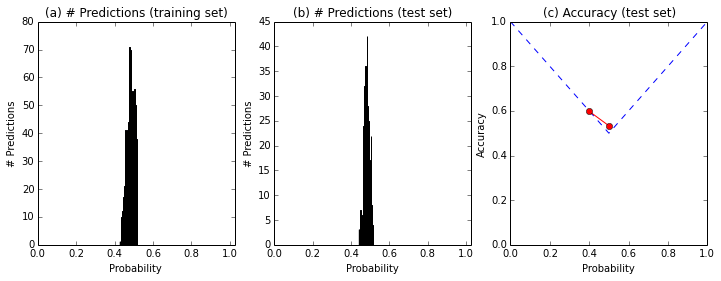

Test set size:	361
----------------------------------------
Precision:	0.522727272727
Recall:		0.153333333333
F1 Score:	0.237113402062
----------------------------------------
TP: 23 | FP: 21 | TN: 189 | FN: 127


In [220]:
learner.test(test_candidates, test_labels)

In [221]:
learner.feature_stats(n_max=10)

,j,w
DDLIB_NUM_WORDS_1,10679,-0.047223
DDLIB_W_RIGHT_POS_1_[NN],3217,-0.040594
DDLIB_W_LEFT_POS_1_[NN],3336,-0.030802
DDLIB_POS_SEQ_[NN],3353,-0.030333
DDLIB_W_LEFT_POS_1_[CC],4427,-0.026109
DDLIB_W_LEFT_POS_1_[JJ],3422,-0.024301
DDLIB_W_LEFT_1_[and],8157,-0.024166
DDLIB_DEP_SEQ_[compound],9174,-0.023339
DDLIB_W_POS_L_1_R_1_[NN]_[NN],1983,-0.016399
DDLIB_NUM_WORDS_2,10677,-0.016104


## Classification performance

First, I'd like to get a sense of how hard it would be to classify unseen classes.

In [78]:
from extractor.util import gold_agg_phen_recall
kb = KnowledgeBase()
id2doc = {doc.name : doc for doc in corpus.documents}
gold_agg_dict_phen = { doc_id : set() for doc_id, phen_id in gold_set_agg_phens }
for doc_id, phen_id in gold_set_agg_phens:
    gold_agg_dict_phen[doc_id].add(phen_id)

for doc in corpus.documents[:10]:
    doc_id = doc.name
    if len(gold_agg_dict_phen[doc_id]) > 3: continue # skip if >3 gwc_phen_ids in doc
    print doc_id
    for phen_id2 in gold_agg_dict_phen[doc_id]: # iterate over gwc_id's in doc
        print agg_id2phen[phen_id2].name, phen_id2 # print its name and id
        for eq_phen in agg_id2phen[phen_id2].equivalents: # loop over equivalent phens
            print '\t', eq_phen.name, eq_phen.ontology_ref, eq_phen.synonyms # print name, ref, synonyms
    print ' '.join(s.text for s in id2doc[doc_id].sentences)
    print

17447842
crohn's disease 19133
	crohn's disease http://www.ebi.ac.uk/efo/EFO_0000384 gastritis associated with crohn's disease|ileitis, terminal|colitis, granulomatous|ileitis, regional|crohn's disease|enteritis, granulomatous|crohns disease|crohns dis|ileocolitis|enteritis, regional|gastritis associated with crohn disease|crohn disease|crohn dis|crohn's associated gastritis
Novel Crohn Disease Locus Identified by Genome-Wide Association Maps to a Gene Desert on 5p13.1 and Modulates Expression of  PTGER4. To identify novel susceptibility loci for Crohn disease (CD), we undertook a genome-wide association study with more than 300,000 SNPs characterized in 547 patients and 928 controls. We found three chromosome regions that provided evidence of disease association with  p -values between 10 −6  and 10 −9 . Two of these ( IL23R  on Chromosome 1 and  CARD15  on Chromosome 16) correspond to genes previously reported to be associated with CD. In addition, a 250-kb region of Chromosome 5p13.

An important experiment to do is to count how many papers support each class.

In [68]:
# How many aggregate classes in total in the database?
from db.kb import db_session
from db.schema import Phenotype, Paper

all_phens=db_session.query(Phenotype).filter(Phenotype.source=='gwas_catalog').all()
all_papers=db_session.query(Paper).all()
len(all_phens), len(all_papers)

(1422, 2088)